<h1><center> Welcome to step 3 and 4 of ML-MotEx </center></h1>

Use this script to take a organized structure catalogue with goodness-of-fit values and predict atom contribution values. The input has to be provided in the following format:

| ID | Rwp value | Number of atoms | Atom #1 | Atom #2 | ... | Atom #N |
|----|-----------|-----------------|---------|---------|-----|---------|
| 1  | 0.55      | 36              | 1       | 0       | ... | 1       |
| 2  | 0.23      | 23              | 0       | 1       | ... | 0       |

The input is used to train a XGBoost regressor and calculate atom contribution values based on the SHAP values of the features as explained in the below pseudo-code.

![Alt text](ML-MotEx/images/Algorithm_Step3_4.png "step3_4.png")

The output is given as a list of atom contribution values providing information about how much each atom contributes to the goodness-of-fit.

# First import modules, set seed parameters and import functions

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, shap
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import pandas as pd

np.random.seed(14)

/home/mrg/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mrg/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [2]:
def Import_Dataset(FileName):
    """This function loads a catalogue of structures with their corresponding Rwp values and split the dataset 
    into a training set and validation set with features and labels."""
    # load data
    dataset = np.loadtxt(FileName, delimiter=" ", skiprows=0)
    dataset_original = dataset.copy()

    # Split into training and validation set
    dataset_train = dataset[:int(len(dataset)*0.8)]
    dataset_val = dataset[int(len(dataset)*0.8):len(dataset)]
    
    # split data into features (X) and labels (y)
    X_train = dataset_train[:,2:len(dataset)+1]
    y_train = dataset_train[:,1]
    X_val = dataset_val[:,2:len(dataset)+1]
    y_val = dataset_val[:,1]
    
    print("Number of Training Data:", len(y_train))
    print("Number of Validation Data:", len(y_val))
        
    return X_train, y_train, X_val, y_val
    
def Validate_XGBoost(model, X_val, y_val):
    """Function to validate the performance of the XGBoost algorithm on a validation set"""
    print ("Giving an estimate of the accuracy of the model")
    xgb_val = xgb.DMatrix(X_val, y_val)
    y_pred_val = model.predict(xgb_val)
    rmse = mean_squared_error(y_val, y_pred_val)
    print("RMSE: %f" % (rmse))
    return rmse

def DecisionTree_CrossValidation(learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=0, 
                                       learning_rate = learning_rate,
                                       max_depth=max_depth) 
    
    cval = cross_val_score(estimator, data, targets, cv=3)
    return cval.mean()

def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        accuracy_mean = DecisionTree_CrossValidation(learning_rate = learning_rate,
                                       max_depth=int(max_depth), 
                                       data=data, targets=targets)
        
        return accuracy_mean
    
    optimizer = BayesianOptimization(f=crossval_wrapper, pbounds=pars, 
                                     random_state=0, verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

def train_w_earlyStop(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, early_stop, xgb_model=None):
    """Train a XGBoost model using the given parameters. The training will run until the early stop criteria is
    fulfilled or 5000 epochs are run. The loss curve and values is saved."""
    start_time = time.time()

    xgb_params = {}
    xgb_params['learning_rate'] = learning_rate
    xgb_params['objective'] = 'reg:squarederror' # Default
    xgb_params['max_depth'] = max_depth
    xgb_params['n_estimators'] = n_estimators
    xgb_params['n_jobs'] = n_jobs
    xgb_params['gamma'] = gamma
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eval_metric'] = ['mae']
    xgb_params['base_score'] = base_score
    xgb_params['seed'] = seed
    xgb_params['verbosity'] = 0
    epochs = 5000

    store = {}
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_val = xgb.DMatrix(X_val, y_val)
    evallist = [(xgb_train,'train'),(xgb_val, 'val')]
    model = None

    model = xgb.train(xgb_params, xgb_train, epochs, evallist, evals_result=store, verbose_eval=0, early_stopping_rounds=early_stop, xgb_model=model)
    print ("Training using the best parameters")
    print("Total execution time: %.3f s" % (time.time()-start_time))
    print ("Training succeeded")
    
    # Save Loss
    loss_results = pd.DataFrame(store)
    loss_results.to_csv("ML_algorithms/LossCurve.csv")

    # Plot Loss
    test_score = store['val']['mae']
    train_score = store['train']['mae']
    plt.plot(range(len(test_score)), test_score, "c", label="Val")
    plt.plot(range(len(train_score)), train_score, "orange", label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend()
    plt.savefig("ML_algorithms/LossCurve.png")
    return model, store

def shap_essential_figure(model, X_train, saveResults):
    """Function that takes a XGBoost model, a training set and calculates SHAP values of each features in the 
    training set. Afterwards, it saves a SHAP summary plot"""
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    # Make SHAP summary plot
    shap.summary_plot(shap_values[:,1:], X_train[:,1:], feature_names=["Atom #"+str(i) for i in range(1,X_train.shape[1])], color_bar_label="Feature Value (Low: Atom Removed, High: Atom Not Removed)", show=False, max_display=X_train.shape[1]) # to plot these explanations
    plt.savefig(saveResults + "/SHAP_values.png", dpi=600, format = "png", bbox_inches='tight')
    return explainer, shap_values

def calculate_atomContributionValue(shap_values, X_train, saveResults):
    """Calculate atom contribution value list from shap values and training set"""
    AtomContributionValues = []
    AtomContributionValues_RMS = []
    for i in range(X_train.shape[1]):
        # We are not interested in the number of atoms in this regi
        if i == 0:
            AtomContributionValues.append(0)
            AtomContributionValues_RMS.append(0)
        else:
            Keep_atoms = np.mean((shap_values[np.where(X_train[:,i] == 1),i]))
            Keep_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 1),i]))
            Remove_atoms = np.mean((shap_values[np.where(X_train[:,i] == 0),i]))
            Remove_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 0),i]))
            AtomContributionValues.append(0.5*Keep_atoms - 0.5*Remove_atoms)
            AtomContributionValues_RMS.append(np.sqrt((0.5*Keep_atoms)**2 + (0.5*Remove_atoms)**2))
    np.savetxt(saveResults + "/AtomContributionValues.txt", AtomContributionValues[1:])
    
    Norm_AtomContributionValues = AtomContributionValues.copy()
    # Normalise the AtomContributionValues and get the RGB color in viridis.reverse
    amin, amax = min(Norm_AtomContributionValues), max(Norm_AtomContributionValues)
    for i, val in enumerate(Norm_AtomContributionValues):
        Norm_AtomContributionValues[i] = (val-amin) / (amax-amin)
    Norm_AtomContributionValues_ph = Norm_AtomContributionValues.copy()
    Norm_AtomContributionValues_ph.sort()
    
    # Normalise such that a threshold is set on the the 10 % lowest and 10 % highest atoms
    norm = mpl.colors.Normalize(vmin=Norm_AtomContributionValues_ph[round((len(Norm_AtomContributionValues))/10)], vmax=Norm_AtomContributionValues_ph[-round((len(Norm_AtomContributionValues))/10)])
    cmap = mpl.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    print ("Atom contribution are calculated to: ")
    for i in range(1,len(AtomContributionValues)):
        
        print ("Atom #", str(i) + ": ", str(AtomContributionValues[i]) + " ± " + str(AtomContributionValues_RMS[i]), " Colorcode: ", mpl.colors.rgb2hex(m.to_rgba(Norm_AtomContributionValues[i])))
    
    return AtomContributionValues, m


# Step 3: Train a XGBoost Regressor to predict the Rwp value based on the structure catalogue
### First define the path of the organized structure catalogue with Rwp values and set range for model optimization. 

It can take a few minutes to train thee XGBoost model. 
N_iter gives a measure of how rounds the model should try to optimize. Set to a low number for a less accurate but fast convergence. 

Number of Training Data: 8000
Number of Validation Data: 2000
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  1        |  0.9719   |  0.4842   |  7.722    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  2        |  0.9769   |  0.5219   |  6.359    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  3        |  0.9748   |  0.3966   |  7.167    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  4        |  0.9652   |  0.4063   |  9.134    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  5        |  0.9583   |  0.1      |  2.0      |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  6        |  0.9748   |  0.7986   |  5.112    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  7        |  0.9755   |  0.1023   |  5.69     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  8        |  0.9672   |  0.7985   |  6.07     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  9        |  0.971    |  0.8      |  2.0      |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  10       |  0.9794   |  0.6927   |  3.332    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  11       |  0.9686   |  0.1      |  10.0     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  12       |  0.9721   |  0.1003   |  8.153    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  13       |  0.9813   |  0.2935   |  4.207    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  14       |  0.9808   |  0.7975   |  4.011    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  15       |  0.983    |  0.4993   |  4.151    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  16       |  0.9828   |  0.4993   |  4.255    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  17       |  0.9786   |  0.5054   |  3.991    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  18       |  0.9827   |  0.4376   |  4.519    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  19       |  0.9529   |  0.7803   |  9.994    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  20       |  0.9829   |  0.4066   |  4.562    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  21       |  0.9721   |  0.1032   |  4.561    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  22       |  0.9827   |  0.6117   |  4.454    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  23       |  0.9828   |  0.5867   |  4.458    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  24       |  0.9823   |  0.5886   |  4.434    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  25       |  0.9821   |  0.581    |  4.392    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  26       |  0.9831   |  0.5692   |  4.437    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  27       |  0.9824   |  0.5798   |  4.38     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  28       |  0.9823   |  0.523    |  4.618    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  29       |  0.9828   |  0.5942   |  4.327    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  30       |  0.9826   |  0.6008   |  4.313    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  31       |  0.9832   |  0.5853   |  4.353    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  32       |  0.9826   |  0.5749   |  4.327    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  33       |  0.9827   |  0.5435   |  4.527    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  34       |  0.9829   |  0.5788   |  4.309    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  35       |  0.9833   |  0.5853   |  4.322    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  36       |  0.9832   |  0.5854   |  4.348    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  37       |  0.9824   |  0.5344   |  4.542    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  38       |  0.9825   |  0.5794   |  4.288    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  39       |  0.9764   |  0.1038   |  6.619    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  40       |  0.9828   |  0.5696   |  4.319    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  41       |  0.9827   |  0.54     |  4.511    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  42       |  0.9831   |  0.6049   |  4.271    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  43       |  0.9826   |  0.5801   |  4.319    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  44       |  0.9827   |  0.5754   |  4.362    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  45       |  0.9819   |  0.5982   |  4.284    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  46       |  0.9831   |  0.5506   |  4.49     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  47       |  0.9829   |  0.5365   |  4.578    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  48       |  0.9831   |  0.5361   |  4.561    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  49       |  0.9824   |  0.5349   |  4.495    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  50       |  0.9825   |  0.5351   |  4.559    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  51       |  0.9828   |  0.5644   |  4.325    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  52       |  0.983    |  0.5709   |  4.309    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  53       |  0.983    |  0.5826   |  4.41     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  54       |  0.9828   |  0.5719   |  4.409    |
Best parameters were:  {'target': 0.9832633568409159, 'params': {'learning_rate': 0.5853309253203431, 'max_depth': 4.322316415433344}}


Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


Training using the best parameters
Total execution time: 6.407 s
Training succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.000238


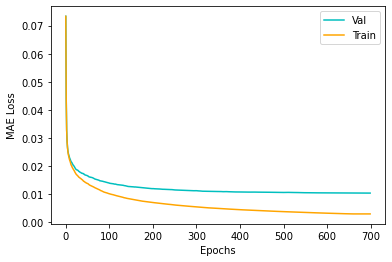

In [3]:
saveFits = "Training_Data/structure_go.txt" # Name of the saved fits file
Min_LR = 0.1 # Minimum learning rate for the XGBoost algorithm
Max_LR = 0.8 # Maximum learning rate for the XGBoost algorithm
Min_Dep = 2 # Minimum max depth for the XGBoost algorithm
Max_Dep = 10 # Maximum max depth for the XGBoost algorithm
n_iter = 50 # Number of iterations for the bayesian optimization model

# Import dataset
X_train, y_train, X_val, y_val = Import_Dataset(saveFits)

# Make a dictionary of parameters we should optimize for the ML algorithm
parameters_BayesianOptimization = {"learning_rate": (Min_LR, Max_LR), #0.1 is default - Boosting learning rate
                                   "max_depth": (Min_Dep, Max_Dep)}  #3 is default - Maximum tree depth for base learners.

# Finding the best parameters for the ML model
BayesianOptimization_func = optimize_DecisionTree(X_train, y_train, parameters_BayesianOptimization, n_iter=n_iter)
print("Best parameters were: ", BayesianOptimization_func.max)


# Get best parameters for the ML model and make max depth to an integer
params = BayesianOptimization_func.max['params']
params['max_depth'] = int(params['max_depth'])

#  Define model, train and validate the model and save model
model, store = train_w_earlyStop(X_train, y_train, n_jobs=1, seed=0, base_score=0.5, n_estimators=100, gamma=0, min_child_weight=1, early_stop=50, **params);
Validate_XGBoost(model, X_val, y_val);
model.save_model("ML_algorithms/109725_XGB_model.dat");


# Step 4: Calculate atom contribution values
### Define the path of where the SHAP values and atom contribution values should be saved. 



Atom contribution are calculated to: 
Atom # 1:  -0.004686655709519982 ± 0.0033141664744310443  Colorcode:  #9c9576
Atom # 2:  -0.0011073838686570525 ± 0.0012053337898273073  Colorcode:  #62656f
Atom # 3:  -0.008538052439689636 ± 0.006037848760559641  Colorcode:  #e5cf52
Atom # 4:  -0.003229592344723642 ± 0.002312849666719557  Colorcode:  #838179
Atom # 5:  -0.005612574750557542 ± 0.003970092428068714  Colorcode:  #aca172
Atom # 6:  -0.0011421966482885182 ± 0.0008616193775865123  Colorcode:  #62656f
Atom # 7:  -0.0011363005032762885 ± 0.0009929802503652243  Colorcode:  #62656f
Atom # 8:  -0.0036551968660205603 ± 0.002620544451410504  Colorcode:  #8a8678
Atom # 9:  -0.0031367653282359242 ± 0.0022235503938522706  Colorcode:  #817f78
Atom # 10:  -0.008784270379692316 ± 0.006211832776642353  Colorcode:  #e9d34e
Atom # 11:  -0.001226565131219104 ± 0.001182510454306298  Colorcode:  #646770
Atom # 12:  -0.004460175288841128 ± 0.0032549791772765358  Colorcode:  #989277
Atom # 13:  -0.015296965

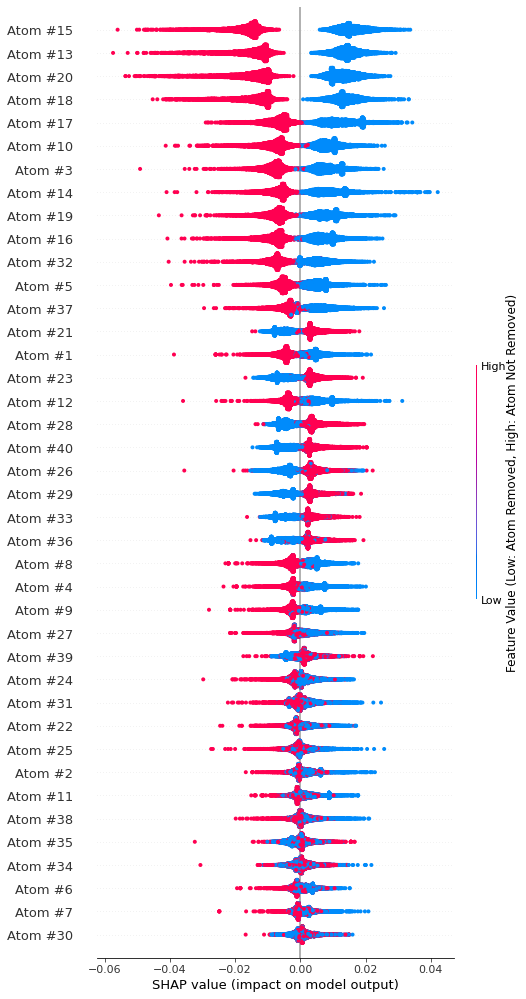

In [4]:
saveResults = "Results/"

# Calculate SHAP values and save to savePATH.
explainer, shap_values = shap_essential_figure(model, X_train, saveResults)

# Calculate atom contribution values
AtomContributionValues, m = calculate_atomContributionValue(shap_values, X_train, saveResults)



# Extra



### We can now make a structure based on the atom contribution values 

As we saw in the script "ML-MotEx-Step1+2", the brute-force approach does not find an alpha-Keggin cluster as the best model. 

Using ML-MotEx, we can now decide which atoms to keep in the model based on the atom contribution value. Here we choose a threshold of 0 meaning that all atoms that contribute to lowering the goodness-of-fit is kept in the model. By doings so, we get a better fit than found with the brute-force model and we obtain the alpha-Keggin cluster. Both the fit from the brute-force model and the structure found with ML-MotEx are shown in the script "ML-MotEx-Step1+2".

![alt text](Images/ML-MotEx_Structure.png "Step3+4")

In [5]:
print(AtomContributionValues)
print(len(AtomContributionValues))

[0, -0.004686655709519982, -0.0011073838686570525, -0.008538052439689636, -0.003229592344723642, -0.005612574750557542, -0.0011421966482885182, -0.0011363005032762885, -0.0036551968660205603, -0.0031367653282359242, -0.008784270379692316, -0.001226565131219104, -0.004460175288841128, -0.01529696537181735, -0.008408688241615891, -0.016773520037531853, -0.00791898719035089, -0.009979825699701905, -0.01455286331474781, -0.008209057617932558, -0.014930949080735445, 0.004663446685299277, -0.0012248755956534296, 0.004503263626247644, -0.0014863145188428462, -0.0013127751590218395, 0.003828510525636375, -0.001987785450182855, 0.004436310729943216, 0.0037458360893651843, 0.0007079592614900321, -0.0012032783415634185, -0.006585402647033334, 0.0037074736319482327, 0.0005365239012462553, 0.0010674111545085907, 0.0036298524355515838, -0.005356492940336466, -0.0012109520976082422, 0.0015204455121420324, 0.004330935189500451]
41


In [6]:
from diffpy.structure import loadStructure

In [7]:
stru = loadStructure("Structure_Models/beta-Ga2O3_CollCode83645_1x2x2.xyz")

In [8]:


def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Output a crystalmaker file to visualize the results
    CrystalMaker = open(saveResults+'CrystalMaker_MotEx.cmtx', 'w')

    CrystalMaker.write("MOLE  CrystalMaker molecule format\n")
    CrystalMaker.write("TITL  Molecule\n\n")
    CrystalMaker.write("! Model type\n")
    CrystalMaker.write("MODL  1\n\n")

    CrystalMaker.write("! Depth fading settings\n")
    CrystalMaker.write("DCUE  1.000000 0.212899 0.704686\n\n")

    CrystalMaker.write("! Colour definitions:\n")
    CrystalMaker.write("TYPE\n")

    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + str(iter+1) + " 1.32 ")
            rgb1 = m.to_rgba(AtomContributionValues[iter])[:-1][0]
            rgb2 = m.to_rgba(AtomContributionValues[iter])[:-1][1]
            rgb3 = m.to_rgba(AtomContributionValues[iter])[:-1][2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
            print(m.to_rgba(AtomContributionValues[iter]))
        else:
            CrystalMaker.write(element + str(iter+1) + " 0.66 ")
            rgb1 = mpl.colors.to_rgb("#FF0000")[0]
            rgb2 = mpl.colors.to_rgb("#FF0000")[1]
            rgb3 = mpl.colors.to_rgb("#FF0000")[2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("! Bond Specifications\n")
    
    # Assign bonds between the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
            for NI_element in NI_elements:
                CrystalMaker.write("BMAX " + element + " " + str(NI_element) + "  " + str(threshold))#    " O  2.6")
                CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("ATOM\n")
    
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")
        else:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")

    CrystalMaker.close()
    
    return None


In [9]:
AtomContributionValues = AtomContributionValues[1:]

In [10]:
NumW = 40



norm = mpl.colors.Normalize(vmin=AtomContributionValues[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues[-round((len(AtomContributionValues))/10)])
cmap = mpl.cm.cividis_r
m = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(AtomContributionValues), vmax=max(AtomContributionValues)), cmap=cmap)

Make_CrystalMakerFile(stru.element, stru.xyz, AtomContributionValues, m, saveResults, 2.5)

(0.431817, 0.43695, 0.449982, 1.0)
(0.279411, 0.318677, 0.423031, 1.0)
(0.597469, 0.570718, 0.465821, 1.0)
(0.373884, 0.389646, 0.434209, 1.0)
(0.468254, 0.468083, 0.464908, 1.0)
(0.28324, 0.32139, 0.423211, 1.0)
(0.28324, 0.32139, 0.423211, 1.0)
(0.391151, 0.403464, 0.438096, 1.0)
(0.37043, 0.38689, 0.433428, 1.0)
(0.609105, 0.579816, 0.463638, 1.0)
(0.287065, 0.324103, 0.423373, 1.0)
(0.421748, 0.428531, 0.44664, 1.0)
(0.93218, 0.840159, 0.28588, 1.0)
(0.593622, 0.567697, 0.466401, 1.0)
(0.995737, 0.909344, 0.217772, 1.0)
(0.570607, 0.549695, 0.469593, 1.0)
(0.664055, 0.623034, 0.450338, 1.0)
(0.89244, 0.80743, 0.324968, 1.0)
(0.582087, 0.55867, 0.468118, 1.0)
(0.91, 0.821885, 0.308594, 1.0)
(0.0, 0.135112, 0.304751, 1.0)
(0.287065, 0.324103, 0.423373, 1.0)
(0.0, 0.138068, 0.311105, 1.0)
(0.298421, 0.332247, 0.423973, 1.0)
(0.290884, 0.326816, 0.423517, 1.0)
(0.0, 0.160495, 0.364534, 1.0)
(0.320595, 0.348565, 0.425889, 1.0)
(0.0, 0.141013, 0.317579, 1.0)
(0.0, 0.163058, 0.371608, 1.0